# 1D Kernel Density Estimation (KDE) Comparison

This notebook compares three implementations of 1D Gaussian Kernel Density Estimation:
1. **Rust `fast_kde`**: Linear binning + Deriche recursive filter approximation (via PyO3).
2. **SciPy `gaussian_kde`**: Standard library implementation (FFT-based for Gaussian kernel).
3. **Naïve KDE with Numba**: Direct summation method, JIT-compiled with Numba.

In [ ]:
# --- Configuration ---
N_SAMPLES = 100_000  # Number of data points to generate
BINS_FAST_KDE = 1024  # Number of bins for fast_kde (and evaluation grid for others)
SIGMA_BANDWIDTH = 0.1  # Gaussian kernel bandwidth (sigma)
SEED = 42  # Random seed for reproducibility

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numba import njit
import timeit
import fast_kde

## 1. Naive KDE Implementation (with Numba)

In [3]:
@njit(cache=True)
def naive_kde_numba(samples: np.ndarray, x_grid: np.ndarray, bandwidth: float) -> np.ndarray:
    """
    Calculates 1D Gaussian KDE using direct summation, accelerated with Numba.
    """
    n_samples = samples.shape[0]
    n_grid_points = x_grid.shape[0]
    pdf_output = np.zeros(n_grid_points, dtype=np.float64)

    if n_samples == 0 or bandwidth <= 0:
        return pdf_output

    # Normalization constant for Gaussian kernel
    norm_const = 1.0 / (np.sqrt(2 * np.pi) * bandwidth * n_samples)

    for j in range(n_grid_points):
        current_x = x_grid[j]
        sum_kernels = 0.0
        for i in range(n_samples):
            diff = (current_x - samples[i]) / bandwidth
            sum_kernels += np.exp(-0.5 * diff * diff)
        pdf_output[j] = norm_const * sum_kernels
    return pdf_output


## 2. Data Generation and Parameters

In [4]:
rng = np.random.default_rng(SEED)

# 複数のガウス分布と一様ノイズを組み合わせたデータ
# 全サンプル数のうち、何割をガウス分布から生成するか (残りが一様ノイズ)
gaussian_fraction = 0.8
num_gaussian_samples = int(N_SAMPLES * gaussian_fraction)
num_uniform_samples = N_SAMPLES - num_gaussian_samples

# ガウス分布のモード設定
# (loc: 平均, scale: 標準偏差, weight: ガウス部分における比率)
gaussian_modes_params = [
    {"loc": -2.0, "scale": 0.3, "weight": 0.35},  # 鋭いモード1
    {"loc": 0.5, "scale": 0.7, "weight": 0.40},  # 広いモード2
    {"loc": 3.0, "scale": 0.2, "weight": 0.25},  # 別の鋭いモード3
]

data_gaussian_components = []
for params in gaussian_modes_params:
    # 各モードのサンプル数を計算
    n_comp = int(num_gaussian_samples * params["weight"])
    data_gaussian_components.append(rng.normal(loc=params["loc"], scale=params["scale"], size=n_comp))

# データの大まかな範囲を推定し、それに合わせて一様ノイズを生成
# ガウス成分の約3シグマ範囲をカバー
est_min = min(p["loc"] - 3 * p["scale"] for p in gaussian_modes_params)
est_max = max(p["loc"] + 3 * p["scale"] for p in gaussian_modes_params)
noise_range_padding = 1.5  # 推定範囲の少し外側までノイズを広げる
uniform_noise = rng.uniform(
    low=est_min - noise_range_padding, high=est_max + noise_range_padding, size=num_uniform_samples
)

# 全ての成分を結合し、シャッフル
sample_data = np.concatenate(data_gaussian_components + [uniform_noise]).astype(np.float64)
np.random.shuffle(sample_data)  # 良い尺度でシャッフル

print(f"Generated {sample_data.shape[0]} data points for a complex distribution.")


# データの範囲とバンド幅に基づいて評価グリッドを決定
x_min_data, x_max_data = np.min(sample_data), np.max(sample_data)
padding = 3 * SIGMA_BANDWIDTH  # データ範囲を超えてグリッドを拡張
x_grid_eval = np.linspace(x_min_data - padding, x_max_data + padding, BINS_FAST_KDE, dtype=np.float64)

print(f"Data range: [{x_min_data:.2f}, {x_max_data:.2f}]")
print(f"Evaluation grid range: [{x_grid_eval.min():.2f}, {x_grid_eval.max():.2f}] with {BINS_FAST_KDE} points.")

Generated 100000 data points for a complex distribution.
Data range: [-4.40, 5.10]
Evaluation grid range: [-4.70, 5.40] with 1024 points.


## 3. "Airshot" for Numba JIT Compilation

In [5]:
# Run Numba-compiled functions once to trigger JIT compilation before benchmarking.
if "naive_kde_numba" in globals():
    print("Performing 'airshot' for Numba JIT compilation of naive_kde_numba...")
    _ = naive_kde_numba(sample_data[:10], x_grid_eval[:10], SIGMA_BANDWIDTH)  # Small subset for quick compile
    print("Numba JIT compilation (airshot) complete.")
else:
    print("Numba function 'naive_kde_numba' not defined. Skipping airshot.")


Performing 'airshot' for Numba JIT compilation of naive_kde_numba...
Numba JIT compilation (airshot) complete.


## 4. Run KDE Estimations

In [10]:
pdf_results = {}
execution_times = {}

# --- 4.1 Rust `fast_kde` ---
print(f"\nRunning Rust fast_kde (bins={BINS_FAST_KDE}, sigma={SIGMA_BANDWIDTH})...")
start_time = timeit.default_timer()
try:
    x_fastkde, pdf_fastkde = fast_kde.kde_deriche(sample_data, BINS_FAST_KDE , SIGMA_BANDWIDTH)
    execution_times["Rust fast_kde"] = timeit.default_timer() - start_time
    pdf_results["Rust fast_kde"] = (x_fastkde, pdf_fastkde)
    print(f"Rust fast_kde execution time: {execution_times['Rust fast_kde']:.4f} seconds")
except Exception as e:
    print(f"Error running fast_kde: {e}")
    pdf_results["Rust fast_kde"] = (None, None)  # Mark as failed

# --- 4.2 SciPy `gaussian_kde` ---
print(f"\nRunning SciPy gaussian_kde (sigma={SIGMA_BANDWIDTH})...")
start_time = timeit.default_timer()

scipy_kde = gaussian_kde(sample_data)  # Init with default (Scott's rule)
scipy_kde.set_bandwidth(
    bw_method=SIGMA_BANDWIDTH / np.std(sample_data, ddof=1)
)  # Set bandwidth using the factor method

pdf_scipy = scipy_kde.evaluate(x_grid_eval)
execution_times["SciPy gaussian_kde"] = timeit.default_timer() - start_time
pdf_results["SciPy gaussian_kde"] = (x_grid_eval, pdf_scipy)  # SciPy uses the same grid for evaluation
print(f"SciPy gaussian_kde execution time: {execution_times['SciPy gaussian_kde']:.4f} seconds")
print(f"  (SciPy effective bandwidth factor: {scipy_kde.covariance_factor()})")
print(f"  (SciPy effective sigma approx: {np.sqrt(scipy_kde.covariance_factor()) * np.std(sample_data, ddof=1):.4f})")

# --- 4.3 Naive KDE with Numba ---
print(f"\nRunning Naive KDE with Numba (sigma={SIGMA_BANDWIDTH})...")
start_time = timeit.default_timer()
pdf_naive_numba = naive_kde_numba(sample_data, x_grid_eval, SIGMA_BANDWIDTH)
execution_times["Naive KDE (Numba)"] = timeit.default_timer() - start_time
pdf_results["Naive KDE (Numba)"] = (x_grid_eval, pdf_naive_numba)
print(f"Naive KDE (Numba) execution time: {execution_times['Naive KDE (Numba)']:.4f} seconds")



Running Rust fast_kde (bins=1024, sigma=0.1)...
Rust fast_kde execution time: 0.0012 seconds

Running SciPy gaussian_kde (sigma=0.1)...
SciPy gaussian_kde execution time: 2.2260 seconds
  (SciPy effective bandwidth factor: 0.0463596429304579)
  (SciPy effective sigma approx: 0.4644)

Running Naive KDE with Numba (sigma=0.1)...
Naive KDE (Numba) execution time: 2.2546 seconds


## 5. Visualization of KDE Results

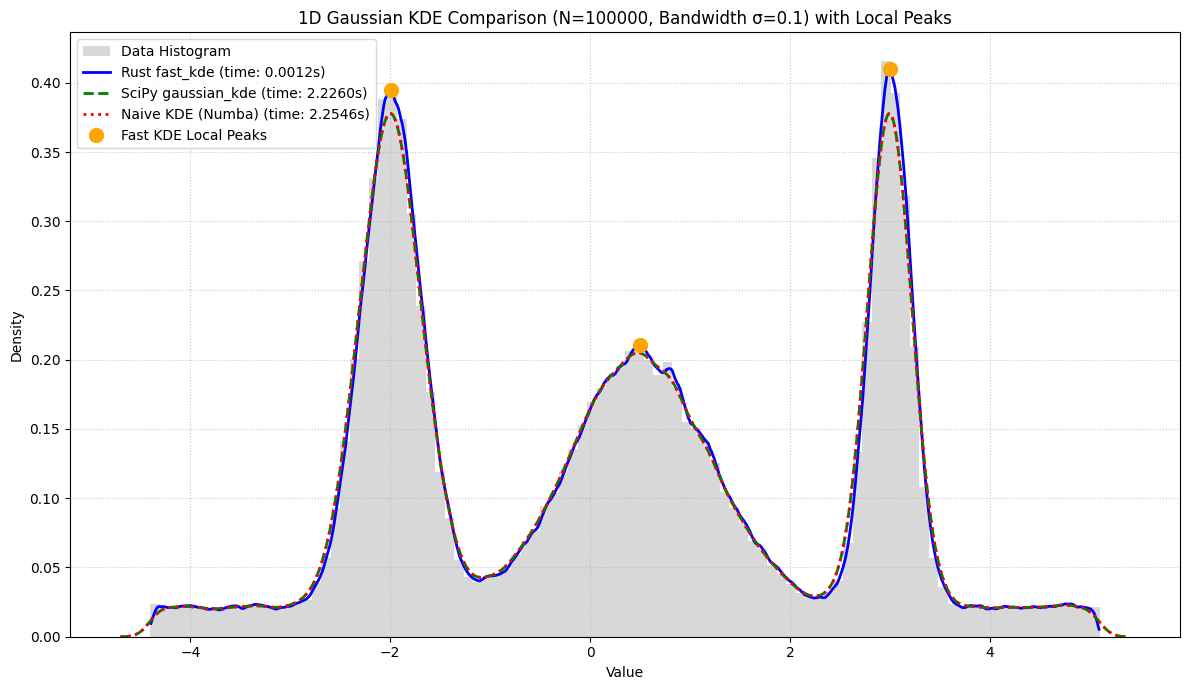

In [15]:
from scipy.signal import find_peaks

plt.figure(figsize=(12, 7))
ax = plt.gca()

# Plot histogram of original data for reference
ax.hist(sample_data, bins=100, density=True, alpha=0.3, label="Data Histogram", color="gray")

line_styles = ["-", "--", ":"]
colors = ["blue", "green", "red"]
method_idx = 0

for method_name, (x_coords, pdf_values) in pdf_results.items():
    if x_coords is not None and pdf_values is not None:
        exec_time = execution_times.get(method_name, float("inf"))
        ax.plot(
            x_coords,
            pdf_values,
            label=f"{method_name} (time: {exec_time:.4f}s)",
            linestyle=line_styles[method_idx % len(line_styles)],
            color=colors[method_idx % len(colors)],
            linewidth=2,
        )
        method_idx += 1
    else:
        print(f"No results to plot for {method_name}")

# Search and visualoze local modes (peaks) for fast_kde
if "Rust fast_kde" in pdf_results and pdf_results["Rust fast_kde"][0] is not None:
    x_fastkde, pdf_fastkde = pdf_results["Rust fast_kde"]
    min_peak_height = pdf_fastkde.max() * 0.3
    bin_interval = (x_fastkde.max() - x_fastkde.min()) / (len(x_fastkde) - 1)
    min_peak_distance = int(0.5 / bin_interval)
    peaks_indices, _ = find_peaks(pdf_fastkde, height=min_peak_height, distance=min_peak_distance)

    local_modes_x = x_fastkde[peaks_indices]
    local_modes_y = pdf_fastkde[peaks_indices]

    ax.plot(local_modes_x, local_modes_y, "o" , color="orange", markersize=10, label="Fast KDE Local Peaks")

ax.set_title(f"1D Gaussian KDE Comparison (N={N_SAMPLES}, Bandwidth σ={SIGMA_BANDWIDTH}) with Local Peaks")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True, linestyle=":", alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Mode Estimation Comparison

In [16]:
mode_results = {}

if fast_kde and pdf_results.get("Rust fast_kde", (None, None))[0] is not None:
    print(f"\nEstimating mode with Rust fast_kde.kde_mode_deriche...")
    start_time = timeit.default_timer()
    try:
        mode_fastkde = fast_kde.kde_mode_deriche(sample_data, BINS_FAST_KDE, SIGMA_BANDWIDTH)
        mode_time = timeit.default_timer() - start_time
        mode_results["Rust fast_kde Mode"] = (mode_fastkde, mode_time)
        print(f"Rust fast_kde mode: {mode_fastkde:.4f} (time: {mode_time:.4f}s)")
    except Exception as e:
        print(f"Error estimating mode with fast_kde: {e}")

# For SciPy and Naive, mode can be found by argmax on the evaluated PDF
for method_name, (x_coords, pdf_values) in pdf_results.items():
    if "Mode" not in method_name and x_coords is not None and pdf_values is not None:
        if len(pdf_values) > 0:
            mode_idx = np.argmax(pdf_values)
            estimated_mode = x_coords[mode_idx]
            # Time for argmax is negligible compared to PDF calculation, so not timed separately here
            mode_results[f"{method_name} (argmax)"] = (estimated_mode, execution_times.get(method_name, 0))
            print(f"{method_name} mode (from PDF argmax): {estimated_mode:.4f}")


Estimating mode with Rust fast_kde.kde_mode_deriche...
Rust fast_kde mode: 2.9983 (time: 0.0009s)
Rust fast_kde mode (from PDF argmax): 2.9983
SciPy gaussian_kde mode (from PDF argmax): -1.9946
Naive KDE (Numba) mode (from PDF argmax): -1.9946


In [17]:
kde_scott = gaussian_kde(sample_data, bw_method='scott')
print(f"Scott's Rule bandwidth: {kde_scott.factor:.4f}") # kde.factor は SciPy 内部の因子

kde_silverman = gaussian_kde(sample_data, bw_method='silverman')
print(f"Silverman's Rule bandwidth: {kde_silverman.factor:.4f}")

# SciPyのfactorは実際にはsigma_kernel / std_dev に対応するので、
# 実際のバンド幅 (sigma_kernel) は factor * std_dev となります。
actual_sigma_scott = kde_scott.factor * np.std(sample_data, ddof=1)
actual_sigma_silverman = kde_silverman.factor * np.std(sample_data, ddof=1)
print(f"Actual Scott's sigma: {actual_sigma_scott:.4f}")
print(f"Actual Silverman's sigma: {actual_sigma_silverman:.4f}")

Scott's Rule bandwidth: 0.1000
Silverman's Rule bandwidth: 0.1059
Actual Scott's sigma: 0.2157
Actual Silverman's sigma: 0.2285
